~~~
Copyright 2025 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
~~~

# Quick start with Hugging Face

<table><tbody><tr>
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/google-health/medasr/blob/main/notebooks/quick_start_with_hugging_face.ipynb">
      <img alt="Google Colab logo" src="https://www.tensorflow.org/images/colab_logo_32px.png" width="32px"><br> Run in Google Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2Fgoogle-health%2Fmedasr%2Fmain%2Fnotebooks%2Fquick_start_with_hugging_face.ipynb">
      <img alt="Google Cloud Colab Enterprise logo" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" width="32px"><br> Run in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/google-health/medasr/blob/main/notebooks/quick_start_with_hugging_face.ipynb">
      <img alt="GitHub logo" src="https://github.githubassets.com/assets/GitHub-Mark-ea2971cee799.png" width="32px"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://huggingface.co/google/medasr">
      <img alt="Hugging Face logo" src="https://huggingface.co/front/assets/huggingface_logo-noborder.svg" width="32px"><br> View on Hugging Face
    </a>
  </td>
</tr></tbody></table>

This notebook provides a basic demo of using MedASR (Medical Automatic Speech Recognition), an automatic speech recognition model trained for medical terms. MedASR is intended to accelerate building healthcare-based AI applications that require audio input.

Learn more about the model on the [HAI-DEF developer site](https://developers.google.com/health-ai-developer-foundations/medasr).

This notebook is for educational purposes only and does not represent a finished or approved product.

## Setup

For an optimal experience, we recommend running this tutorial on a system equipped with an NVIDIA Tesla T4 GPU or higher. While the tutorial can run on a CPU, performance will be significantly slower.

You can try running the notebook on Google Colab with a free T4 GPU:

1. In the upper-right of the Colab window where it reads **Connect**, select **▾ (Additional connection options)**.
2. Select **Change runtime type**.
3. Under Hardware accelerator, select **T4 GPU**.

### Get access to MedASR

Before you get started, make sure that you have access to MedASR models on Hugging Face:

1. If you don't already have a Hugging Face account, you can create one for free by clicking [here](https://huggingface.co/join).
2. Head over to the [MedASR model page](https://huggingface.co/google/medasr) and accept the usage conditions.

### Install dependencies

In [ ]:
! uv pip install accelerate bitsandbytes git+https://github.com/huggingface/transformers.git@65dc261512cbdb1ee72b88ae5b222f2605aad8e5 levenshtein jiwer librosa

**Important**: Please restart your runtime after reinstalling transformers from Git.
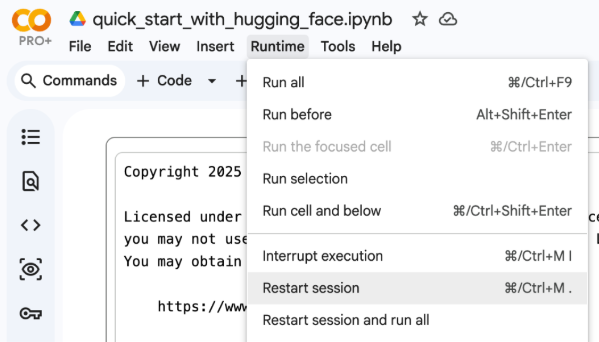

### Authenticate with Hugging Face

Generate a Hugging Face `read` access token by going to [settings](https://huggingface.co/settings/tokens).

If you are using Google Colab, add your access token to the Colab Secrets manager to securely store it. If not, proceed to run the cell below to authenticate with Hugging Face.

1. Open your Google Colab notebook and click on the 🔑 Secrets tab in the left panel. <img src="https://storage.googleapis.com/generativeai-downloads/images/secrets.jpg" alt="The Secrets tab is found on the left panel." width=50%>
2. Create a new secret with the name `HF_TOKEN`.
3. Copy/paste your token key into the Value input box of `HF_TOKEN`.
4. Toggle the button on the left to allow notebook access to the secret.

In [ ]:
import os
import sys

google_colab = "google.colab" in sys.modules and not os.environ.get("VERTEX_PRODUCT")

if google_colab:
    # Use secret if running in Google Colab
    from google.colab import userdata
    os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
else:
    # Store Hugging Face data under `/content` if running in Colab Enterprise
    if os.environ.get("VERTEX_PRODUCT") == "COLAB_ENTERPRISE":
        os.environ["HF_HOME"] = "/content/hf"
    # Authenticate with Hugging Face
    ! uv pip install huggingface_hub
    from huggingface_hub import get_token
    if get_token() is None:
        from huggingface_hub import notebook_login
        notebook_login()

### Retrieve sample data


In [ ]:
import huggingface_hub
from IPython.display import Audio, display

audio = huggingface_hub.hf_hub_download('google/medasr', 'test_audio.wav')
sample_transcript = "Exam type CT chest PE protocol period. Indication 54 year old female, shortness of breath, evaluate for PE period. Technique standard protocol period. Findings colon. Pulmonary vasculature colon. The main PA is patent period. There are filling defects in the segmental branches of the right lower lobe comma compatible with acute PE period. No saddle embolus period. Lungs colon. No pneumothorax period. Small bilateral effusions comma right greater than left period. New paragraph. Impression colon Acute segmental PE right lower lobe period."
display(Audio(audio, autoplay=False))
model_id = "google/medasr"


### Define utility functions to evaluate Word Error Rate (WER)

In [ ]:
# @title
import re
import jiwer
import Levenshtein

def normalize(s: str) -> str:
  s = s.lower()
  s = s.replace('</s>', '')
  s = re.sub(r"[^ a-z0-9']", ' ', s)
  s = ' '.join(s.split())
  return s

def _colored(text, color):
    if color == 'red':
        return f"\033[91m{text}\033[0m"
    elif color == 'green':
        return f"\033[92m{text}\033[0m"
    return text

def evaluate(
    ref_text: str,
    hyp_text: str,
    delete_color: str = 'red',
    insert_color: str = 'green',
) -> None:
  print('HYP:', hyp_text)
  normalized_ref = normalize(ref_text)
  normalized_hyp = normalize(hyp_text)

  # Calculate word lists early so we can use them for both jiwer and diffs
  ref_words = normalized_ref.split()
  hyp_words = normalized_hyp.split()

  # jiwer.process_words expects a list of strings (sentences) or list of list of words
  measures = jiwer.process_words([normalized_ref], [normalized_hyp])

  # Calculate edit operations using Levenshtein for the colored diff
  edits = Levenshtein.editops(ref_words, hyp_words)

  r = 0 # Index for the reference words for diff building
  diff = ''

  for op, i, j in edits:
    # Add matched words before the current edit
    if r < i:
      diff += ' ' + ' '.join(ref_words[r:i])
    r = i # Update reference index for next iteration

    if op == 'replace':
      diff += (
          f' {_colored(f"{{-{ref_words[i]}-}}", delete_color)}'
          f' {_colored(f"{{+{hyp_words[j]}+}}", insert_color)}'
      )
      r += 1 # Advance reference index after replacement
    elif op == 'insert':
      diff += f' {_colored(f"{{+{hyp_words[j]}+}}", insert_color)}'
      # Reference index `r` does not advance for an insertion
    elif op == 'delete':
      diff += f' {_colored(f"{{-{ref_words[i]}-}}", delete_color)}'
      r += 1 # Advance reference index after deletion

  # Add any remaining matched words from the reference
  if r < len(ref_words):
    diff += ' ' + ' '.join(ref_words[r:])

  print(
      f'WER: {measures.wer * 100:.2f}%: '
      f'insertions {measures.insertions}, deletions {measures.deletions}, substitutions {measures.substitutions}, '
      f'ref tokens {len(ref_words)}'
  )
  print(diff)

## Run inference on sample audio

The following sections contain standalone examples demonstrating how to use the model both directly and with the [`pipeline`](https://huggingface.co/docs/transformers/en/main_classes/pipelines) API. The `pipeline` API provides a simple way to use the model for inference while abstracting away complex details,  while directly using the model gives you complete control over the inference process, including preprocessing and postprocessing. In practice, you should select the method that is best suited for your use case.



**Run model with the `pipeline` API**

In [ ]:
from transformers import pipeline

pipe = pipeline("automatic-speech-recognition", model=model_id)
result = pipe(audio,chunk_length_s=20, stride_length_s=2)
# the chunk length is how long in seconds MedASR segments audio and the stride length is the overlap between chunks.
print(result)
evaluate(ref_text=sample_transcript, hyp_text=result['text'])

**Use a language model to further improve MedASR**

We also include a n-gram SentencePiece language model for improving the output quality. Here's an example of how it can be used.

In [ ]:
# We must install a modified version of pyctcdecode which is compatible with
# newer versions of `transformers`.
#
# Please use Python 3.12 (e.g. `uv venv --python=3.12`) if kenlm cannot be
# installed under newer Python versions [https://github.com/kpu/kenlm/pull/473].
! uv pip install kenlm==0.3.0 git+https://github.com/mediacatch/pyctcdecode.git@ff49fc562bf8fc5d6697d4dcd34188dd630cc977

import dataclasses
import pyctcdecode
import transformers

def _restore_text(text: str) -> str:
  return text.replace(" ", "").replace("#", " ").replace("</s>", "").strip()


class LasrCtcBeamSearchDecoder:

  def __init__(
      self,
      tokenizer: transformers.LasrTokenizer,
      kenlm_model_path=None,
      **kwargs,
  ):
    vocab = [None for _ in range(tokenizer.vocab_size)]
    for k, v in tokenizer.vocab.items():
      if v < tokenizer.vocab_size:
        vocab[v] = k
    assert not [i for i in vocab if i is None]
    # pyctcdecode also expect the blank label to map to the empty string.
    vocab[0] = ""
    # Replace '▁' with '#' and prefix each token with a '▁'. This way, pyctcdecode
    # treats each token as a "word".
    for i in range(1, len(vocab)):
      piece = vocab[i]
      if not piece.startswith("<") and not piece.endswith(">"):
        piece = "▁" + piece.replace("▁", "#")
      vocab[i] = piece
    self._decoder = pyctcdecode.build_ctcdecoder(
        vocab, kenlm_model_path, **kwargs
    )

  def decode_beams(self, *args, **kwargs):
    beams = self._decoder.decode_beams(*args, **kwargs)
    return [dataclasses.replace(i, text=_restore_text(i.text)) for i in beams]


def beam_search_pipe(model: str, lm: str):
  feature_extractor = transformers.LasrFeatureExtractor.from_pretrained(model)
  feature_extractor._processor_class = "LasrProcessorWithLM"
  pipe = transformers.pipeline(
      task="automatic-speech-recognition",
      model=model,
      feature_extractor=feature_extractor,
      decoder=LasrCtcBeamSearchDecoder(
          transformers.AutoTokenizer.from_pretrained(model), lm
      ),
  )
  assert pipe.type == "ctc_with_lm"
  return pipe

pipe_with_lm = beam_search_pipe(
    model_id,
    huggingface_hub.hf_hub_download(model_id, filename='lm_6.kenlm'),
)

result_with_lm = pipe_with_lm(
    audio,
    chunk_length_s=20,
    stride_length_s=2,
    decoder_kwargs=dict(beam_width=8),
)
evaluate(ref_text=sample_transcript, hyp_text=result_with_lm["text"])

**Run model directly**

In [ ]:
import librosa
import torch
from transformers import AutoModelForCTC, AutoProcessor

device = "cuda" if torch.cuda.is_available() else "cpu"

# 1. Setup
processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForCTC.from_pretrained(model_id).to(device)

# 2. Load audio with librosa
# We use the 'audio' variable from the earlier cell which contains the local path to the downloaded file.
# We explicitly set sr=16000 because most speech models expect 16kHz audio.
speech, sample_rate = librosa.load(audio, sr=16000)

# 3. Preprocess
inputs = processor(speech, sampling_rate=sample_rate)
inputs = inputs.to(device)

# 4. Inference
# Here we do not segment audio at all.
outputs = model.generate(**inputs)
decoded_text = processor.batch_decode(outputs)[0]
evaluate(ref_text=sample_transcript, hyp_text=decoded_text)

## Run inference on your own audio recording

This section demonstrates how you can record your own speech and test the model.


### Write transcript of recording

Start by editing the transcript field below to reflect the speech you'd like to record.

In [ ]:
import pprint

transcript = "FINDINGS:  LUNGS AND PLEURA: There is a focal airspace opacity in the right lower lobe, consistent with airspace disease. The remaining lung parenchyma is clear. There is no evidence of pneumothorax or significant pleural effusion.  HEART AND MEDIASTINUM: The cardiac silhouette is normal in size. The mediastinal and hilar contours are unremarkable.  BONES: The visualized osseous structures, including the ribs, clavicles, and thoracic spine, are unremarkable for acute fracture or lytic lesion.  SOFT TISSUES: The overlying soft tissues are unremarkable."  # @param {type: "string"}
pprint.pprint(transcript)

### Record audio


In [ ]:
# @title #### Define helper functions to record audio

import base64
from google.colab import output

def receive_audio_data_simplified(base64_audio, filename):
    # Decode the base64 string
    audio_bytes = base64.b64decode(base64_audio)

    # Save the file to the Colab local filesystem
    with open(filename, 'wb') as f:
        f.write(audio_bytes)

    print(f"Saved audio file to: {filename}")

# Register the callback so JavaScript can call it
output.register_callback('receive_audio_data_simplified', receive_audio_data_simplified)

Now press play in the next code cell and dictate the words in the transcript above and we'll see how good MedASR is at recognizing your voice.

In [ ]:
# @title
%%javascript
(async () => {
  const display = (msg) => {
    const div = document.createElement('div');
    div.innerHTML = msg;
    document.body.appendChild(div);
  };

  const html = `
    <div>
      <button id="record">Start Recording</button>
      <button id="stop" disabled>Stop Recording</button>
      <button id="play" disabled>Play Recording</button>
      <audio id="audioPlayback" controls style="margin-top: 10px;"></audio>
      <div id="status" style="margin-top: 10px;">Click "Start Recording" to begin.</div>
    </div>
  `;
  display(html);

  const recordButton = document.getElementById('record');
  const stopButton = document.getElementById('stop');
  const playButton = document.getElementById('play');
  const audioPlayback = document.getElementById('audioPlayback');
  const statusDiv = document.getElementById('status');

  let mediaRecorder;
  let audioChunks = [];
  let audioBlob;

  const enableButtons = (record, stop, play) => {
    recordButton.disabled = !record;
    stopButton.disabled = !stop;
    playButton.disabled = !play;
  };

  const sendAudioToPython = async (blob, filename) => {
    if (!blob) {
      statusDiv.innerText = 'No audio recorded to save.';
      return;
    }
    enableButtons(false, false, false);
    statusDiv.innerText = 'Sending audio data to Python...';
    const reader = new FileReader();
    reader.onloadend = async () => {
      const base64data = reader.result.split(',')[1];
      try {
        await google.colab.kernel.invokeFunction('receive_audio_data_simplified', [base64data, filename], {});
        statusDiv.innerText = 'Audio data sent to Python successfully.';
        enableButtons(true, false, true);
      } catch (e) {
        statusDiv.innerText = 'Error sending audio data to Python: ' + e.message;
        enableButtons(true, false, true);
      }
    };
    reader.readAsDataURL(blob);
  };

  recordButton.onclick = async () => {
    statusDiv.innerText = 'Requesting microphone access...';
    try {
        if (!mediaRecorder) {
            const stream = await navigator.mediaDevices.getUserMedia({ audio: true });
            mediaRecorder = new MediaRecorder(stream);

            mediaRecorder.ondataavailable = event => {
                audioChunks.push(event.data);
            };

            mediaRecorder.onstop = async () => {
                audioBlob = new Blob(audioChunks, { type: 'audio/webm' });
                const audioUrl = URL.createObjectURL(audioBlob);
                audioPlayback.src = audioUrl;
                statusDiv.innerText = 'Recording stopped. Saving audio...';
                enableButtons(false, false, false);
                const filename = "test_audio_1.webm";
                sendAudioToPython(audioBlob, filename);
                audioChunks = [];
            };
        }

        audioChunks = [];
        mediaRecorder.start();
        statusDiv.innerText = 'Recording... Click "Stop Recording" to finish.';
        enableButtons(false, true, false);
    } catch (err) {
        statusDiv.innerText = 'Error accessing microphone: ' + err.message;
        console.error(err);
    }
  };

  stopButton.onclick = () => {
    mediaRecorder.stop();
    statusDiv.innerText = 'Processing recording...';
    enableButtons(false, false, false);
  };

  playButton.onclick = () => {
    audioPlayback.play();
    statusDiv.innerText = 'Playing recorded audio.';
  };

})();

### Run inference on recorded audio

In [ ]:
hyp_text = pipe("test_audio_1.webm")['text']
print(hyp_text)
evaluate(ref_text=transcript, hyp_text=hyp_text)

## Next steps

Explore the other [notebooks](https://github.com/google-health/medasr/blob/main/notebooks) to learn what else you can do with the model.